**IMPLEMENTATION CODE**

**MINI PROJECT REVIEW 3**

**LONG SHORT TERM MEMORY MODEL IMPLEMENTATION**

**4 THREAD INPUT MODEL BUILDING**

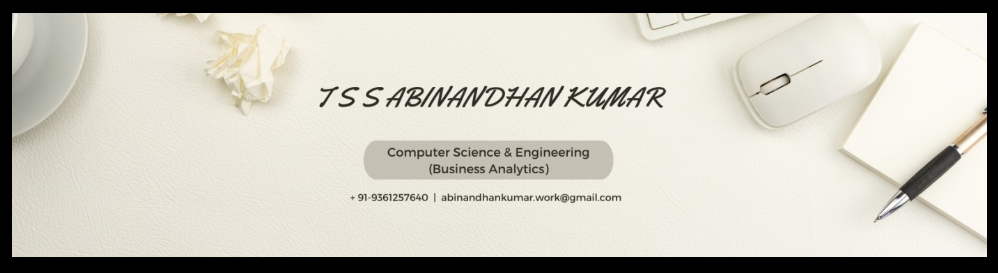

**PROJECT TITLE**

**TACKLING COMPLEX SCIENTIFIC QUESTIONS USING LARGE LANGUAGE MODEL**

**NAME : T S S Abinandhan Kumar**

**REGISTER NUMBER : 19MIA1062**

In [ ]:
import numpy as np
import pandas as pd

**IMPORTING LIBRARIES**

In [ ]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import random
from sklearn.model_selection import KFold
from tensorflow.keras.layers import concatenate

In [ ]:
LABEL_DICT = {"A":0,'B':1,'C':2,'D':3,'E':4}

In [ ]:
def read_data(path,check_test= False):
    df = pd.read_csv(path)
    X_Prompt = tf.convert_to_tensor(df.prompt.to_list())
    X_A = tf.convert_to_tensor(df.A.to_list())
    X_B = tf.convert_to_tensor(df.B.to_list())
    X_C = tf.convert_to_tensor(df.C.to_list())
    X_D = tf.convert_to_tensor(df.D.to_list())
    X_E = tf.convert_to_tensor(df.E.to_list())

    Selects = {'A':X_A,"B":X_B,"C":X_C,'D':X_D,'E':X_E}

    Labels = labels_one_hot = None


    if not check_test:
        labels = df.answer.to_list()
        labels_one_hot = [LABEL_DICT.get(i) for i in labels]

        label_A = []
        label_B = []
        label_C = []
        label_D = []
        label_E = []

        for i in labels:
            if i =='A':
                label_A.append(0.8)
                label_B.append(0.05)
                label_C.append(0.05)
                label_D.append(0.05)
                label_E.append(0.05)
            if i =='B':
                label_B.append(0.8)
                label_A.append(0.05)
                label_C.append(0.05)
                label_D.append(0.05)
                label_E.append(0.05)

            if i =='C':
                label_C.append(0.8)
                label_A.append(0.05)
                label_B.append(0.05)
                label_D.append(0.05)
                label_E.append(0.05)
            if i =='D':
                label_D.append(0.8)
                label_A.append(0.05)
                label_B.append(0.05)
                label_C.append(0.05)
                label_E.append(0.05)
            if i =='E':
                label_E.append(0.8)
                label_A.append(0.05)
                label_B.append(0.05)
                label_C.append(0.05)
                label_D.append(0.05)
        label_A = tf.convert_to_tensor(label_A)
        label_B = tf.convert_to_tensor(label_B)
        label_C = tf.convert_to_tensor(label_C)
        label_D = tf.convert_to_tensor(label_D)
        label_E = tf.convert_to_tensor(label_E)


        Labels  = {'A': label_A,'B': label_B,'C': label_C,'D': label_D,'E': label_E}

    return {'Prompt':X_Prompt,'Selects':Selects,'labels':Labels,'label_onehot':labels_one_hot}


In [ ]:
def read_data_binary(path,test = False):
    df = pd.read_csv(path)
    X_Prompt = df.prompt.to_list()
    X_A = df.A.to_list()
    X_B = df.B.to_list()
    X_C = df.C.to_list()
    X_D = df.D.to_list()
    X_E = df.E.to_list()

    labels_num = None
    if not test:
        labels_old = df.answer.to_list()
        labels_num = [LABEL_DICT.get(i) for i in labels_old]

    questions= []
    answers = []
    labels = []
    label_num_new = []
    for i in range(len(X_Prompt)):
        for j in range(5):
            questions.append(X_Prompt[i])
        answers.append(X_A[i])
        answers.append(X_B[i])
        answers.append(X_C[i])
        answers.append(X_D[i])
        answers.append(X_E[i])
        if not test:
            one_hot_label = np.full((5,),0.35)
            one_hot_label[labels_num[i]] =1.0
            for j in one_hot_label:
                labels.append(j)
            for i in range(5):
                label_num_new.append(labels_num[i])

    questions = tf.convert_to_tensor(questions)
    answers = tf.convert_to_tensor(answers)
    labels = tf.convert_to_tensor(labels)

    return {'Prompt':questions,'Answers':answers,'labels':labels,'label_nums':labels_num}

**INPUT TRAIN**

In [ ]:
path_train = '/content/drive/MyDrive/kaggle-llm-science-exam/extra_train_set.csv'
result = read_data(path_train,False)
X_Prompt = result.get('Prompt')
X_A = result.get('Selects').get('A')
X_B = result.get('Selects').get('B')
X_C = result.get('Selects').get('C')
X_D = result.get('Selects').get('D')
X_E = result.get('Selects').get('E')

Selects = [result.get('Selects')[i] for i in result.get('Selects') ]
Selects.insert(0,X_Prompt)
labels = [result.get('labels')[i] for i in result.get('labels') ]
labels_one_hot = result.get('label_onehot')
labels_one_hot_train = tf.one_hot(labels_one_hot, depth=5)

In [ ]:
path_val = '/content/drive/MyDrive/kaggle-llm-science-exam/train.csv'
result_val = read_data(path_val ,False)
X_Prompt_val  = result_val .get('Prompt')
X_A_val  = result_val .get('Selects').get('A')
X_B_val  = result_val .get('Selects').get('B')
X_C_val  = result_val .get('Selects').get('C')
X_D_val  = result_val .get('Selects').get('D')
X_E_val  = result_val .get('Selects').get('E')

Selects_val  = [result_val .get('Selects')[i] for i in result_val .get('Selects') ]
Selects_val .insert(0,X_Prompt_val )
labels_val  = [result_val .get('labels')[i] for i in result_val .get('labels') ]
labels_one = result_val .get('label_onehot')
labels_one_hot_val = tf.one_hot(labels_one, depth=5)

**LOAD MODEL BERT**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

**BUILD MODEL**

In [ ]:
text_Prompt = tf.keras.layers.Input(shape=(), dtype=tf.string)
text_A = tf.keras.layers.Input(shape=(), dtype=tf.string)
text_B = tf.keras.layers.Input(shape=(), dtype=tf.string)
text_C = tf.keras.layers.Input(shape=(), dtype=tf.string)
text_D = tf.keras.layers.Input(shape=(), dtype=tf.string)
text_E = tf.keras.layers.Input(shape=(), dtype=tf.string)

encoder_prompt_input = bert_preprocess(text_Prompt)
encoder_A_input = bert_preprocess(text_A)
encoder_B_input = bert_preprocess(text_B)
encoder_C_input = bert_preprocess(text_C)
encoder_D_input = bert_preprocess(text_D)
encoder_E_input = bert_preprocess(text_E)

encoder_prompt = concatenate(
        tuple([bert_encoder(encoder_prompt_input)['encoder_outputs'][i] for i in range(-4, 0)]),
        name = 'hidden_states_prompt_1',
        axis = -1
    )[:, 0, :]
encoder_A = concatenate(
        tuple([bert_encoder(encoder_A_input)['encoder_outputs'][i] for i in range(-4, 0)]),
        name = 'hidden_states_A',
        axis = -1
    )[:, 0, :]
encoder_B = concatenate(
        tuple([bert_encoder(encoder_B_input)['encoder_outputs'][i] for i in range(-4, 0)]),
        name = 'hidden_states_B',
        axis = -1
    )[:, 0, :]
encoder_C = concatenate(
        tuple([bert_encoder(encoder_C_input)['encoder_outputs'][i] for i in range(-4, 0)]),
        name = 'hidden_states_C',
        axis = -1
    )[:, 0, :]
encoder_D = concatenate(
        tuple([bert_encoder(encoder_D_input)['encoder_outputs'][i] for i in range(-4, 0)]),
        name = 'hidden_states_D',
        axis = -1
    )[:, 0, :]
encoder_E = concatenate(
        tuple([bert_encoder(encoder_E_input)['encoder_outputs'][i] for i in range(-4, 0)]),
        name = 'hidden_states_E',
        axis = -1
    )[:, 0, :]
print(encoder_E.shape)

reshape_prompt = tf.reshape(encoder_prompt, (-1, 4, 768))
reshape_A = tf.reshape(encoder_A, (-1, 4, 768))
reshape_B = tf.reshape(encoder_B, (-1, 4, 768))
reshape_C = tf.reshape(encoder_C, (-1, 4, 768))
reshape_D = tf.reshape(encoder_D, (-1, 4, 768))
reshape_E = tf.reshape(encoder_E, (-1, 4, 768))
print('reshape: ', reshape_A.shape)
# layer A
concat_encoder_A = concatenate([reshape_prompt,reshape_A,reshape_B,reshape_C,reshape_D,reshape_E],axis = 1)
LSTM = tf.keras.layers.LSTM(units=32,dropout=0.2, recurrent_dropout=0.2,return_sequences=True)(concat_encoder_A)
Dense_prompt_A = tf.keras.layers.Dense(32,activation = 'relu')(LSTM)
Dense_prompt_A =  tf.keras.layers.Dropout(0.3)(Dense_prompt_A)
Dense_prompt_A = tf.keras.layers.LayerNormalization()(Dense_prompt_A)
Linear_A =  tf.keras.layers.Dropout(0.3)(Dense_prompt_A)
classifer = keras.layers.Flatten()(Linear_A)
classifer = tf.keras.layers.Dense(5,activation = 'linear')(classifer)
classifer =  tf.keras.layers.Dense(5,activation = 'softmax')(classifer)

model = keras.Model(inputs=[text_Prompt, text_A,text_B,text_C,text_D,text_E], outputs=classifer)
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

(None, 3072)
reshape:  (None, 4, 768)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None,)]            0           []                               
                                                      

In [ ]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=5,
                    restore_best_weights=True,
                )

In [ ]:
model.fit(x = Selects,y = labels_one_hot_train,batch_size=32,
          epochs=50,
         validation_data=(Selects_val, labels_one_hot_val) )

Epoch 1/50
16/16 [==============================] - 164s 7s/step - loss: 2.1544 - accuracy: 0.2400 - val_loss: 1.8676 - val_accuracy: 0.2400
Epoch 2/50
16/16 [==============================] - 97s 6s/step - loss: 2.1891 - accuracy: 0.1980 - val_loss: 1.6922 - val_accuracy: 0.1600
Epoch 3/50
16/16 [==============================] - 97s 6s/step - loss: 2.0599 - accuracy: 0.2200 - val_loss: 1.6701 - val_accuracy: 0.2300
Epoch 4/50
16/16 [==============================] - 97s 6s/step - loss: 1.9605 - accuracy: 0.2220 - val_loss: 1.6685 - val_accuracy: 0.1900
Epoch 5/50
16/16 [==============================] - 97s 6s/step - loss: 1.8782 - accuracy: 0.2560 - val_loss: 1.7653 - val_accuracy: 0.1550
Epoch 6/50
16/16 [==============================] - 97s 6s/step - loss: 1.9026 - accuracy: 0.2520 - val_loss: 1.6909 - val_accuracy: 0.2250
Epoch 7/50
16/16 [==============================] - 97s 6s/step - loss: 1.8260 - accuracy: 0.2340 - val_loss: 1.7116 - val_accuracy: 0.1900
Epoch 8/50
16/16 [=

KeyboardInterrupt: 

In [ ]:
y_predict = model.predict(Selects)
top_three_indices = (-y_predict).argsort(axis = 1)[:, :3].tolist()
top_max = np.argmax(y_predict,axis = -1)
report = classification_report(labels_one_hot, top_max)
print(report)

In [ ]:
count = 0
for i in range(len(labels_one_hot)):
    if labels_one_hot[i] in top_three_indices[i]:
        count +=1
print(count)

In [ ]:
y_predict = model.predict(Selects_val)
top_three_indices = (-y_predict).argsort(axis = 1)[:, :3].tolist()
top_max = np.argmax(y_predict,axis = -1)
report = classification_report(labels_one, top_max)
print(report)

In [ ]:
count = 0
for i in range(len(labels_one)):
    if labels_one[i] in top_three_indices[i]:
        count +=1
print(count)

**DATA TEST**

In [ ]:
path_test = '/kaggle/input/kaggle-llm-science-exam/test.csv'
result_bianry = read_data_binary(path_test,True)
Questions = result_bianry.get('Prompt')
Answers = result_bianry.get('Answers')
Labels = result_bianry.get('labels')
Label_nums = result_bianry.get('label_nums')
Selects = []
Selects.append(Questions)
Selects.append(Answers)

In [ ]:
path_test = '/content/drive/MyDrive/kaggle-llm-science-exam/test.csv'
result = read_data(path_test,True)
X_Prompt = result.get('Prompt')
X_A = result.get('Selects').get('A')
X_B = result.get('Selects').get('B')
X_C = result.get('Selects').get('C')
X_D = result.get('Selects').get('D')
X_E = result.get('Selects').get('E')

Selects = [result.get('Selects')[i] for i in result.get('Selects') ]
Selects.insert(0,X_Prompt)

In [ ]:
y_predict = model.predict(Selects)
top_three_indices = (-y_predict).argsort(axis = 1)[:, :3].tolist()
top_max = np.argmax(y_predict,axis = -1)

*Write CSV submission*

In [ ]:

df_resutl =  pd.read_csv("/content/drive/MyDrive/kaggle-llm-science-exam/sample_submission.csv")
x = ['A','B','C','D',"E"]
Label_test = [' '.join([x[int(j)] for j in i]) for i in top_three_indices]

for i in range(len(Label_test)):
    df_resutl.at[i, 'prediction'] = str(Label_test[i])
df_resutl.to_csv('LSTM_Output.csv', index=False)